# Propuesta de Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: `Geraldine Coli Acevedo`, `Carlos Olguín`, `René Saavedra Vargas`.  

## 1. Introducción

El siguiente cuaderno presenta un avance de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realizan evaluaciones de modelos de recomendación sobre un conjunto de datos de ratings de Amazon (enfocado en Videojuegos). El conjunto de datos se obtiene a partir de [Amazon Review Data (2023)](https://amazon-reviews-2023.github.io) de McAuley Lab. En particular se utiliza el conjunto **Video Games (Review, Metadata)** para obtener los ratings de los videojuegos y su información asociada.

Para ejecutar este cuaderno, es necesario descargar los archivos y descomprimirlos en la carpeta `data/`.

## 2. Pasos preliminares

### 2.1. Variables

In [10]:
TEST_SIZE = 0.1
DATASET_SIZE = 0.01
RANDOM_STATE = 42
MIN_REVIEW_COUNT = 10

### 2.2. Instalación de dependencias


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from prettytable import PrettyTable
from scipy.sparse import vstack

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import LabelEncoder

# Surprise 
from surprise import Dataset, Reader, KNNBasic, SVD

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch_geometric.data import HeteroData
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

### 2.3. Cargar datos

In [ ]:
metadata_path   = os.path.join('data', 'meta_Video_Games.jsonl')
video_games_path = os.path.join('data', 'Video_Games.jsonl')

metadata_df    = pd.read_json(metadata_path, lines=True)
video_games_df = pd.read_json(video_games_path, lines=True)

print(metadata_df.shape, metadata_df.columns)
print(video_games_df.shape, video_games_df.columns)

(137269, 16) Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')
(4624615, 10) Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [73]:
df = video_games_df.copy()

usuario_real = 'AEAPUOTLUYEHM4JIPMMPLCWH64HA'

table = PrettyTable()
table.field_names = df.columns.tolist()

for index, row in df[df['user_id'] == 'AEAPUOTLUYEHM4JIPMMPLCWH64HA'].iterrows():
    table.add_row(row.tolist())

print(table)

+--------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------+-------------+------------------------------+----------------------------+--------------+-------------------+
| rating |      title       |                                                                                               text                                                                                              | images |    asin    | parent_asin |           user_id            |         timestamp          | helpful_vote | verified_purchase |
+--------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------+-------------+------------------------------+

### 2.4. Preprocesar datos

Debido a que el conjunto de datos es muy grande y con un sparcity alto (muchos itemes y muchos usuarios con 1 sola review), se decide trabajar con un subconjunto de los datos. En particular, se seleccionan solo los usuarios que han hecho al menos `MIN_REVIEW_COUNT` reseñas.
```python

In [11]:
filtered_df = video_games_df[
    video_games_df.groupby('user_id')['user_id'].transform('count') > MIN_REVIEW_COUNT
].copy()

print(video_games_df.shape, filtered_df.shape)

filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
filtered_df = filtered_df.sort_values('timestamp').reset_index(drop=True)

(4624615, 10) (415636, 10)


Separamos los usuarios para que todos los usuarios en test se hayan visto en el entrenamiento. (Dejamos el último item calificado en test, elemento a predecir la recomendación).

In [12]:
train_parts = []
test_parts  = []

for user_id, group in filtered_df.groupby('user_id'):
    test_parts.append(group.iloc[-2:])   
    train_parts.append(group.iloc[:-2])  

train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)


In [ ]:
print(train_df.shape, test_df.shape)

(767039, 10) (81305, 10)


In [13]:
def df_stats(interactions_df, metadata_df):
    # ————— Estadísticas de interacciones —————
    n_users = interactions_df['user_id'].nunique()
    n_items = interactions_df['parent_asin'].nunique()
    total_ratings = len(interactions_df)
    avg_rpu = round(total_ratings / n_users, 1) if n_users > 0 else 0.0
    avg_rpi = round(total_ratings / n_items, 1) if n_items > 0 else 0.0
    avg_rating = round(interactions_df['rating'].mean(), 1) if total_ratings > 0 else 0.0
    std_rating = round(interactions_df['rating'].std(), 1) if total_ratings > 1 else 0.0

    if total_ratings > 0:
        max_by_user = int(interactions_df.groupby('user_id').size().max())
        max_by_item = int(interactions_df.groupby('asin').size().max())
    else:
        max_by_user = 0
        max_by_item = 0

    # ————— Estadísticas de descripciones —————
    relevant_asins = interactions_df['parent_asin'].unique()
    filtered_metadata = metadata_df[metadata_df['parent_asin'].isin(relevant_asins)].copy()

    # Normalizar las descripciones (convertir listas a strings)
    def normalize_desc(x):
        if isinstance(x, list):
            return ' '.join([str(fragment) for fragment in x if fragment])
        elif isinstance(x, str):
            return x
        else:
            return ''

    desc_series = filtered_metadata['description'].apply(normalize_desc)
    desc_word_counts = desc_series.apply(lambda txt: len(txt.split()) if txt.strip() else 0)

    n_items_with_desc = int((desc_word_counts > 0).sum())
    n_items_without_desc = int((desc_word_counts == 0).sum())

    if n_items_with_desc > 0:
        min_len = int(desc_word_counts[desc_word_counts > 0].min())
        max_len = int(desc_word_counts.max())
        mean_len = round(desc_word_counts[desc_word_counts > 0].mean(), 1)
        std_len = round(desc_word_counts[desc_word_counts > 0].std(), 1)
    else:
        min_len = 0
        max_len = 0
        mean_len = 0.0
        std_len = 0.0

    return {
        # — Estadísticas de interacciones —
        'Número de usuarios'                  : n_users,
        'Número de ítems'                    : n_items,
        'Cantidad total de ratings'          : total_ratings,
        'Promedio de ratings por usuario'     : avg_rpu,
        'Promedio de ratings por ítem'       : avg_rpi,
        'Rating promedio'                    : avg_rating,
        'Desviación estándar del rating'     : std_rating,
        'Máximo de ratings por usuario'      : max_by_user,
        'Máximo de ratings por ítem'         : max_by_item,

        # — Estadísticas de descripciones —
        'Número de ítems sin descripción'    : n_items_without_desc,
        'Número de ítems con descripción'    : n_items_with_desc,
        'Longitud mínima de descripción'     : min_len,
        'Longitud máxima de descripción'     : max_len,
        'Longitud promedio de descripción'   : mean_len,
        'Desviación estándar longitud descr' : std_len,
    }


In [14]:
stats_train = df_stats(train_df, metadata_df)
stats_test = df_stats(test_df, metadata_df)

table = PrettyTable()
table.field_names = ["Estadística", "Train", "Test"]
for key in stats_train.keys():
    table.add_row([key, stats_train[key], stats_test[key]])

print(table)


+------------------------------------+--------+-------+
|            Estadística             | Train  |  Test |
+------------------------------------+--------+-------+
|         Número de usuarios         | 21834  | 21834 |
|          Número de ítems           | 52633  | 18029 |
|     Cantidad total de ratings      | 371968 | 43668 |
|  Promedio de ratings por usuario   |  17.0  |  2.0  |
|    Promedio de ratings por ítem    |  7.1   |  2.4  |
|          Rating promedio           |  4.3   |  4.2  |
|   Desviación estándar del rating   |  1.2   |  1.3  |
|   Máximo de ratings por usuario    |  662   |   2   |
|     Máximo de ratings por ítem     |  776   |  129  |
|  Número de ítems sin descripción   | 15202  |  5589 |
|  Número de ítems con descripción   | 37431  | 12440 |
|   Longitud mínima de descripción   |   1    |   1   |
|   Longitud máxima de descripción   | 15942  |  3817 |
|  Longitud promedio de descripción  | 184.2  | 207.5 |
| Desviación estándar longitud descr | 292.8  | 

### 2.5. Analisis de datos

Realizamos gráficos para analizar los datos sobre la cantidad de ratings, distribución de los usuarios e itemes.

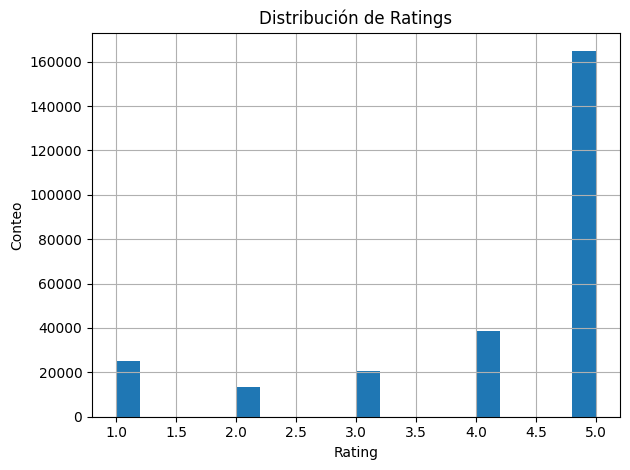

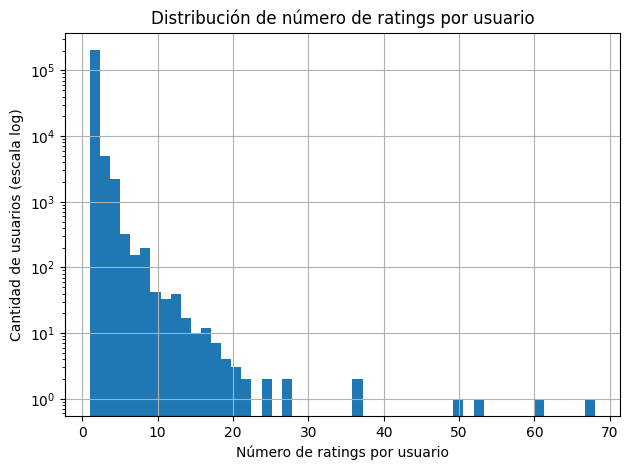

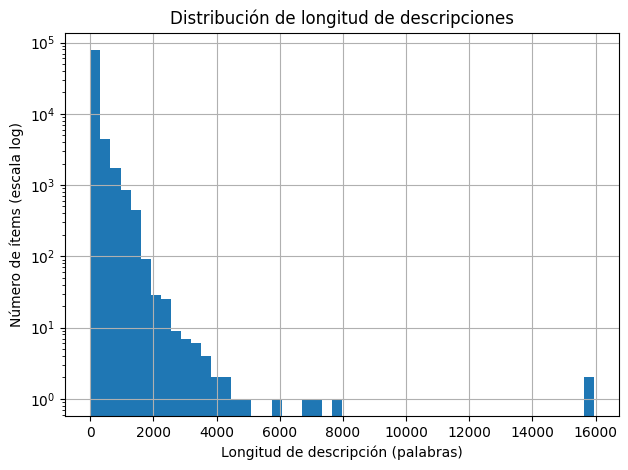

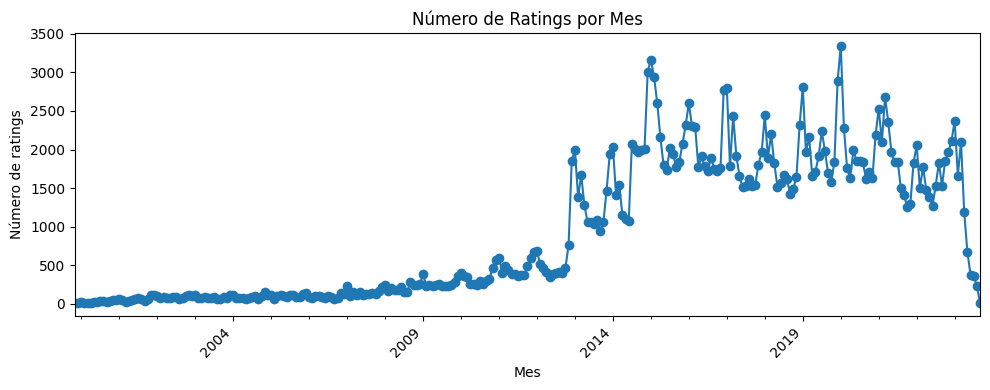

In [ ]:
# 1. Histograma de distribución de ratings
plt.figure()
df['rating'].hist(bins=20)
plt.xlabel('Rating')
plt.ylabel('Conteo')
plt.title('Distribución de Ratings')
plt.tight_layout()

# 2. Histograma de número de ratings por usuario (escala logarítmica)
user_counts = df.groupby('user_id').size()
plt.figure()
user_counts.hist(bins=50, log=True)
plt.xlabel('Número de ratings por usuario')
plt.ylabel('Cantidad de usuarios (escala log)')
plt.title('Distribución de número de ratings por usuario')
plt.tight_layout()

# 3. Histograma de longitud de descripciones (solo ítems con descripción)
def normalize_desc(x):
    if isinstance(x, list):
        return ' '.join([str(fragment) for fragment in x if fragment])
    elif isinstance(x, str):
        return x
    else:
        return ''

desc = metadata_df['description'].apply(normalize_desc).fillna('')
desc_lens = desc.apply(lambda t: len(t.split()) if t.strip() else 0)
plt.figure()
desc_lens[desc_lens > 0].hist(bins=50, log=True)
plt.xlabel('Longitud de descripción (palabras)')
plt.ylabel('Número de ítems (escala log)')
plt.title('Distribución de longitud de descripciones')
plt.tight_layout()

# 4. Serie de tiempo: número de ratings por mes
df['year_month'] = df['timestamp'].dt.to_period('M')

monthly_counts = df.groupby('year_month').size().sort_index()
plt.figure(figsize=(10, 4))
monthly_counts.plot(marker='o', linestyle='-')
plt.xlabel('Mes')
plt.ylabel('Número de ratings')
plt.title('Número de Ratings por Mes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



## 3. Modelos de prueba

#### 3.1. Modelos simples

Funciones auxiliares para mostrar las recomendaciones de los modelos.

In [16]:
def asin_to_title(asin: str) -> str:
    """
    Dada un ASIN, devuelve el título del videojuego.
    """
    if asin in metadata_df['parent_asin'].values:
        return metadata_df.loc[metadata_df['parent_asin'] == asin, 'title'].values[0]
    else:
        return "Título no encontrado"
    
def print_recommendations(recommendations: list):
    """
    Imprime las recomendaciones con sus títulos.
    """
    print("Recomendaciones:")
    for asin in recommendations:
        title = asin_to_title(asin)
        print(f"- {title} (ASIN: {asin})")
    

Realizamos pruebas con diferentes modelos simples de referencia. Utilizamos una clase RecomendadorBase que se utiliza para crear los otros recomendadores.

In [ ]:
class RecomendadorBase:
    """
    Clase base para todos los recomendadores.
    Formato a utilizar: userId, itemId, rating
    """
    def fit(self, df: pd.DataFrame):
        raise NotImplementedError

    def recommend(self, user_id, n_items=10):
        raise NotImplementedError

Recomendadores base, Random y Most Popular. Estos recomendadores no utilizan información de los usuarios ni de los ítems, sino que se basan en estrategias simples para generar recomendaciones. Utilizados para comparar con los modelos más complejos.


In [ ]:
class RecomendadorRandom(RecomendadorBase):
    """
    Recomendador aleatorio.
    """
    def fit(self, df: pd.DataFrame):
        self.df = df['parent_asin'].unique().tolist()

    def recommend(self, user_id, n_items=10):
        recs = np.random.choice(self.df, size=n_items, replace=False)
        return recs.tolist()
    
class RecomendadorPopular(RecomendadorBase):
    """
    Recomendador basado en popularidad.
    """
    def fit(self, df: pd.DataFrame):
        train_pos = df[df['rating'] >= 4]

        pop_counts = (
            train_pos
            .groupby('parent_asin')
            .size()
            .reset_index(name='pos_count')
            .sort_values('pos_count', ascending=False)
        )
        
        self.most_popular_list = pop_counts['parent_asin'].tolist()

    def recommend(self, user_id, n_items=10):
        return self.most_popular_list[:n_items]


#### 3.2. Modelo basado en contenido

Creamos un recomendador basado en contenido que utiliza la metadata de las reviews de los usuarios (Título y descripción de la review hecha), utilizamos TF-IDF para vectorizar el texto y luego utilizamos un modelo de similitud de coseno para generar recomendaciones basadas en el contenido de las reviews.

In [ ]:
class RecomendadorContent(RecomendadorBase):
    """
    Recomendador basado en contenido (TF-IDF + cosine).
    """
    def fit(self, df: pd.DataFrame, max_features=5000):
        self.df = df

        # Utiliza la review del usuario como texto para el TF-IDF
        df['text_features'] = (
            df['title'].fillna('') + ' ' +
            df['text'].fillna('')
        )

        self.tfidf = TfidfVectorizer(max_features=max_features)
        self.item_tfidf = self.tfidf.fit_transform(df['text_features'])

        self.item_to_idx = {asin: idx for idx, asin in enumerate(df['parent_asin'])}
        self.asin_list = list(df['parent_asin'])

    def recommend(self, user_id, n_items=10):
        # 1) Obtenemos los ítems que el usuario ha valorado >= 4 en el DF de entrenamiento
        
        user_hist = self.df[(self.df['user_id'] == user_id) & (self.df['rating'] >= 4)]['parent_asin'].tolist()
        
        if not user_hist:
            # Si no hay historial positivo, caemos al recomendador de popularidad (Fallback)
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 2) Convertir el historial a índices TF-IDF
        idx_list = [self.item_to_idx[asin] for asin in user_hist if asin in self.item_to_idx]
        if not idx_list:
            # Si ninguno de los ASIN del historial está en metadata_df
            popular_recommender = RecomendadorPopular()
            popular_recommender.fit(self.df)
            return popular_recommender.recommend(user_id, n_items)

        # 3) Calcular vector de perfil del usuario (media de sus vectores TF-IDF)
        user_vec = vstack([self.item_tfidf[i] for i in idx_list]).mean(axis=0)
        user_vec = np.asarray(user_vec) # Arregla error en python 3.11

        sims = linear_kernel(user_vec, self.item_tfidf).flatten()  # ya es np.ndarray

        # 4) Ordenar de mayor a menor similitud y filtrar los ya vistos
        top_indices = np.argsort(sims)[::-1]
        recs = []
        seen = set(self.df[self.df['user_id'] == user_id]['parent_asin'].tolist())
        for idx in top_indices:
            cand_asin = self.asin_list[idx]
            if cand_asin not in seen:
                recs.append(cand_asin)
                if len(recs) == n_items:
                    break

        return recs


In [ ]:
content_recommender = RecomendadorContent()
content_recommender.fit(train_df)

In [23]:
print("Recomendaciones de contenido para un usuario random:")
user_id = train_df['user_id'].sample().iloc[0]
content_recs = content_recommender.recommend(user_id, n_items=10)
print_recommendations(content_recs)


Recomendaciones de contenido para un usuario random:
Recomendaciones:
- FUNLAB Switch Controller Wireless Compatible with Switch/OLED/Lite, Bluetooth Remote Gamepad with 7 LED Colors/Paddle Buttons/Turbo/Motion Control (ASIN: B08DKVN2TR)
- Razer Wildcat eSports Customizable Premium Controller for Xbox One W/ 4 Programmable Buttons (ASIN: B0177G3QV4)
- Hawksbill Nintendo Switch Compatible Handheld Controller, Plug and Play, Charging, Turbo and Auto Function (ASIN: B09KT2TZK1)
- Xbox One + Kinect (ASIN: B00CMQTVUA)
- Xbox One with Kinect (Day One Edition) (ASIN: B00CMQTVK0)
- PDP Gaming Faceoff Deluxe+ Wired Switch Pro Controller - Officially Licensed by Nintendo - Customizable buttons, sticks, triggers, and paddles - Ergonomic Controllers - Purple Camo / Camouflage (ASIN: B09MFFTCX8)
- PowerA FUSION Pro 2 Wired Controller for Xbox Series X|S, gamepad, video game controller, works with Xbox One (ASIN: B08XXWJ787)
- UNCHARTED: The Nathan Drake Collection - PlayStation 4 (ASIN: B00YQM1PNY)

#### 3.3. Modelo basado en DeepFM

Realizamos un modelo basado en DeepFM que utiliza las características de los usuarios e ítems para generar recomendaciones. Utilizamos la librería `nn` para crear el modelo y entrenarlo. El modelo DeepFM combina un modelo de factorización de matrices con un modelo de red neuronal para generar recomendaciones. (Clase DeepFM)

Verificar que el dispositivo sea GPU y que torch esté instalado correctamente.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


Creación modelo DeepFM:
- Código adaptado de una implementación [DeepFM](https://github.com/chenxijun1029/DeepFM_with_PyTorch/blob/master/model/DeepFM.py) de chenxijun1029 y la documentación de [PyTorch](https://pytorch.org/docs/stable/index.html).

In [ ]:
class DeepFM(nn.Module):
    def __init__(self, num_users: int, num_items: int,
                 embed_dim: int = 16, mlp_dims: list = [64, 32], dropout: float = 0.2):

        super().__init__()

        self.user_linear = nn.Embedding(num_users, 1)
        self.item_linear = nn.Embedding(num_items, 1)

        self.global_bias = nn.Parameter(torch.zeros(1))
        self.user_bias   = nn.Embedding(num_users, 1)
        self.item_bias   = nn.Embedding(num_items, 1)

        self.user_fm = nn.Embedding(num_users, embed_dim)
        self.item_fm = nn.Embedding(num_items, embed_dim)

        mlp_input_dim = embed_dim * 2
        layers = []
        for hidden_dim in mlp_dims:
            layers.append(nn.Linear(mlp_input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            mlp_input_dim = hidden_dim
        layers.append(nn.Linear(mlp_input_dim, 1)) 
        self.mlp = nn.Sequential(*layers)

        nn.init.xavier_uniform_(self.user_linear.weight)
        nn.init.xavier_uniform_(self.item_linear.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        nn.init.xavier_uniform_(self.user_fm.weight)
        nn.init.xavier_uniform_(self.item_fm.weight)
        for module in self.mlp:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

    def forward(self, user_idx: torch.LongTensor, item_idx: torch.LongTensor) -> torch.Tensor:
        lin_u = self.user_linear(user_idx)
        lin_i = self.item_linear(item_idx)
        ub    = self.user_bias(user_idx)
        ib    = self.item_bias(item_idx)

        linear_out = self.global_bias + lin_u + lin_i + ub + ib   


        fm_u = self.user_fm(user_idx)
        fm_i = self.item_fm(item_idx)
        sum_emb    = fm_u + fm_i                    # (batch, embed_dim)
        sum_emb_sq = sum_emb * sum_emb              # (batch, embed_dim)
        sq_emb     = fm_u * fm_u + fm_i * fm_i      # (batch, embed_dim)
        fm2 = 0.5 * torch.sum(sum_emb_sq - sq_emb, dim=1, keepdim=True)  

        concat = torch.cat([fm_u, fm_i], dim=1)  
        deep_out = self.mlp(concat)             

        out = linear_out + fm2 + deep_out      
        return out.squeeze(1)    


In [ ]:
class RecomendadorDeepFM:
    def __init__(
        self,
        metadata_df: pd.DataFrame,  
        device: str = 'auto',
        embed_dim: int = 16,
        mlp_dims: list = [64, 32],
        dropout: float = 0.2,
        lr: float = 1e-3,
        batch_size: int = 1024,
        epochs: int = 10,
    ):
        self.metadata_df = metadata_df.copy()

        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        print(f"[RecomendadorDeepFM] Device: {self.device}")

        self.embed_dim = embed_dim
        self.mlp_dims = mlp_dims
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

        self.user_enc = None
        self.item_enc = None
        self.model = None
        self.train_df = None
        self.popularity = None  

    def fit(self, df: pd.DataFrame):
 
        data = df.dropna(subset=['user_id', 'parent_asin', 'rating']).copy()

        self.user_enc = LabelEncoder()
        data['user_idx'] = self.user_enc.fit_transform(data['user_id'])

        self.item_enc = LabelEncoder()
        data['item_idx'] = self.item_enc.fit_transform(data['parent_asin'])

        self.train_df = data[['user_id', 'parent_asin', 'user_idx', 'item_idx', 'rating']].copy()
        self.popularity = (
            data.groupby('parent_asin')['rating']
                .mean()
                .sort_values(ascending=False)
        )

        num_users = len(self.user_enc.classes_)
        num_items = len(self.item_enc.classes_)
        print(f"→ num_users = {num_users}, num_items = {num_items}")

        user_idxs = data['user_idx'].values.astype(np.int64)
        item_idxs = data['item_idx'].values.astype(np.int64)
        ratings   = data['rating'].values.astype(np.float32)

        class SimpleDataset(Dataset):
            def __init__(self, u, i, r):
                self.u = u
                self.i = i
                self.r = r
            def __len__(self):
                return len(self.r)
            def __getitem__(self, idx):
                return self.u[idx], self.i[idx], self.r[idx]

        full_dataset = SimpleDataset(user_idxs, item_idxs, ratings)
        
        val_size = int(0.1 * len(full_dataset))
        train_size = len(full_dataset) - val_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, drop_last=True)
        val_loader   = DataLoader(val_set,   batch_size=self.batch_size, shuffle=False)

        self.model = DeepFM(
            num_users, num_items,
            embed_dim=self.embed_dim,
            mlp_dims=self.mlp_dims,
            dropout=self.dropout
        )
        self.model.to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        patience = 2

        for epoch in range(self.epochs):
            # (a) Training 
            self.model.train()
            total_train_loss = 0.0
            for u_batch, i_batch, r_batch in train_loader:
                u_batch = u_batch.to(self.device)  # (batch,)
                i_batch = i_batch.to(self.device)  # (batch,)
                r_batch = r_batch.to(self.device)  # (batch,)

                optimizer.zero_grad()
                preds = self.model(u_batch, i_batch)  # (batch,)
                loss  = criterion(preds, r_batch)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item() * r_batch.size(0)

            avg_train_loss = total_train_loss / len(train_set)

            # (b) Validacion
            self.model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for u_batch, i_batch, r_batch in val_loader:
                    u_batch = u_batch.to(self.device)
                    i_batch = i_batch.to(self.device)
                    r_batch = r_batch.to(self.device)
                    val_preds = self.model(u_batch, i_batch)
                    val_loss = criterion(val_preds, r_batch)
                    total_val_loss += val_loss.item() * r_batch.size(0)

            avg_val_loss = total_val_loss / len(val_set)
            print(f"Epoch {epoch+1}/{self.epochs} → Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss - 1e-5:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save(self.model.state_dict(), "best_deepfm_simple.pt")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Stopping early at epoch {epoch+1} (no improvement).")
                    break

        self.model.load_state_dict(torch.load("best_deepfm_simple.pt"))
        self.model.eval()
        print(f"[Training complete] Best Val MSE = {best_val_loss:.4f}")

    def recommend(self, user_id, n_items=10):

        if user_id not in set(self.train_df['user_id'].unique()):
            return list(self.popularity.head(n_items).index)

        user_idx = self.user_enc.transform([user_id])[0]

        seen_items = set(self.train_df[self.train_df['user_id'] == user_id]['parent_asin'])

        all_items = np.array(self.item_enc.classes_)      #
        all_item_idxs = np.arange(len(self.item_enc.classes_))

        user_idxs = np.full_like(all_item_idxs, fill_value=user_idx, dtype=np.int64)
        user_idxs_tensor = torch.LongTensor(user_idxs).to(self.device)
        item_idxs_tensor = torch.LongTensor(all_item_idxs).to(self.device)

        with torch.no_grad():
            scores = self.model(user_idxs_tensor, item_idxs_tensor).cpu().numpy()  # (num_items,)

        candidates = []
        for idx, score in enumerate(scores):
            asin = all_items[idx]
            if asin not in seen_items:
                candidates.append((asin, score))

        candidates.sort(key=lambda x: x[1], reverse=True)
        top_n = [asin for asin, _ in candidates[:n_items]]
        return top_n


In [45]:
train_df.columns 

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'text_features'],
      dtype='object')

In [47]:
deepfm_recommender = RecomendadorDeepFM(metadata_df, lr=1e-5, epochs=10, batch_size=1024, embed_dim=16, mlp_dims=[64, 32], dropout=0.2)
deepfm_recommender.fit(train_df)

[RecomendadorDeepFM] Device: cuda
→ num_users = 21834, num_items = 52633
Epoch 1/10 → Train MSE: 19.3355 | Val MSE: 19.2514
Epoch 2/10 → Train MSE: 19.0115 | Val MSE: 18.8936
Epoch 3/10 → Train MSE: 18.6299 | Val MSE: 18.4793
Epoch 4/10 → Train MSE: 18.1817 | Val MSE: 17.9994
Epoch 5/10 → Train MSE: 17.6661 | Val MSE: 17.4454
Epoch 6/10 → Train MSE: 17.0715 | Val MSE: 16.8081
Epoch 7/10 → Train MSE: 16.3914 | Val MSE: 16.0907
Epoch 8/10 → Train MSE: 15.6311 | Val MSE: 15.2947
Epoch 9/10 → Train MSE: 14.7979 | Val MSE: 14.4251
Epoch 10/10 → Train MSE: 13.8965 | Val MSE: 13.4931
[Training complete] Best Val MSE = 13.4931


In [55]:
user_id = train_df['user_id'].sample().iloc[0]
recommendations = deepfm_recommender.recommend(user_id, n_items=10)

print(f"Recomendaciones para el usuario {user_id}:")
print_recommendations(recommendations)

Recomendaciones para el usuario AEAPUOTLUYEHM4JIPMMPLCWH64HA:
Recomendaciones:
- Grand Theft Auto V: Premium Edition - Xbox One [Digital Code] (ASIN: B0086VPUHI)
- amFilm Tempered Glass Screen Protector for Nintendo Switch 2017 (2-Pack) (ASIN: B01N3ASPNV)
- Skyrim VR - PlayStation 4 (ASIN: B07YBXFDYN)
- Fallout 4 - Xbox One (ASIN: B07YBWT3PK)
- PlayStation 4 500GB Console [Old Model][Discontinued] (ASIN: B00BGA9WK2)
- The Last of Us - PlayStation 3 (ASIN: B007CM0K86)
- Far Cry 4 - PS3 [Digital Code] (ASIN: B00KIWEMIG)
- Battlefield 3 - Playstation 3 (ASIN: B004LLHFAW)
- The Legend of Zelda: Breath of the Wild Master Edition - Nintendo Switch (ASIN: B087NNPYP3)
- Assassin's Creed IV Black Flag - PC (ASIN: B00BN5T30E)


### 3.4. Modelo basado en Grafos

Utilizamos torch geometric para crear un modelo basado en grafos. Este modelo utiliza la estructura de los datos para generar recomendaciones basadas en la relación entre los usuarios e ítems. Utilizamos un modelo de GCN para generar las recomendaciones. (Clase GCN)

In [ ]:
# Clase LightGCNConv para la propagación de mensajes
class LightGCNConv(MessagePassing):
    def __init__(self):
        super().__init__(aggr='add')
    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
    
# Clase LightGCN que implementa el modelo LightGCN
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=16, n_layers=3):
        super().__init__()
        # Parámetros del modelo, incluyendo embeddings para usuarios e ítems
        self.n_layers = n_layers
        self.user_emb = nn.Embedding(num_users, embed_dim)
        self.item_emb = nn.Embedding(num_items, embed_dim)
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
        torch.nn.init.xavier_uniform_(self.user_emb.weight)
        torch.nn.init.xavier_uniform_(self.item_emb.weight)

    def forward(self, data):
        # Forward pass del modelo LightGCN
        x_user = self.user_emb.weight
        x_item = self.item_emb.weight
        x = torch.cat([x_user, x_item], dim=0)
        edge_ui = data['user', 'to', 'item'].edge_index.clone()
        edge_iu = data['item', 'to', 'user'].edge_index.clone()
        edge_iu[0] += data['user'].num_nodes
        edge_ui[1] += data['user'].num_nodes
        edge_index = torch.cat([edge_ui, edge_iu], dim=1)
        all_emb = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            all_emb.append(x)
        final_emb = torch.stack(all_emb, dim=1).mean(dim=1)
        user_final = final_emb[: data['user'].num_nodes, :]
        item_final = final_emb[data['user'].num_nodes :, :]
        return user_final, item_final

C:\Users\René\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Con las clases definidas, creamos el recomendador basado en grafos. Este modelo utiliza la estructura de los datos para generar recomendaciones basadas en la relación entre los usuarios e ítems. Utilizamos la función `build_graph` para crear el grafo y luego utilizamos el modelo GCN para generar las recomendaciones.

In [ ]:
"""
Código basado de implementación de LightGCN en PyTorch hecho por gusye1234:
https://github.com/gusye1234/LightGCN-PyTorch/blob/master

LightGCN (He et al., SIGIR 2020)
""" 
class RecomendadorGrafos: # Recomendador basado en LightGCN
    def __init__(self, device: str = 'auto', embed_dim: int = 16, n_layers: int = 3,
                 lr: float = 1e-3, epochs: int = 10, batch_size: int = 1024):
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.user_enc = None
        self.item_enc = None
        self.model = None
        self.data = None
        self.user2items = {}
        self.df_copy = None

    def build_graph(self, df: pd.DataFrame):
        num_users = len(self.user_enc.classes_)
        num_items = len(self.item_enc.classes_)
        data = HeteroData()
        data['user'].num_nodes = num_users
        data['item'].num_nodes = num_items
        user_idxs = df['user_idx'].values
        item_idxs = df['item_idx'].values
        edge_ui = torch.tensor([user_idxs, item_idxs], dtype=torch.long)
        edge_iu = torch.tensor([item_idxs, user_idxs], dtype=torch.long)
        data['user', 'to', 'item'].edge_index = edge_ui
        data['item', 'to', 'user'].edge_index = edge_iu
        return data

    def bpr_loss(self, u_emb, i_pos_emb, i_neg_emb):
        pos_scores = torch.sum(u_emb * i_pos_emb, dim=1)
        neg_scores = torch.sum(u_emb * i_neg_emb, dim=1)
        return -F.logsigmoid(pos_scores - neg_scores).mean()

    def sample_bpr_batch(self, df, user2items, num_items):
        users = random.choices(list(user2items.keys()), k=self.batch_size)
        pos_items, neg_items = [], []
        for u in users:
            pos = random.choice(list(user2items[u]))
            while True:
                neg = random.randint(0, num_items - 1)
                if neg not in user2items[u]:
                    break
            pos_items.append(pos)
            neg_items.append(neg)
        return torch.LongTensor(users), torch.LongTensor(pos_items), torch.LongTensor(neg_items)

    def fit(self, df: pd.DataFrame):
        self.df_copy = df
        
        data = df.dropna(subset=['user_id', 'parent_asin']).copy()
        self.user_enc = LabelEncoder()
        data['user_idx'] = self.user_enc.fit_transform(data['user_id'])
        self.item_enc = LabelEncoder()
        data['item_idx'] = self.item_enc.fit_transform(data['parent_asin'])
        self.user2items = {}
        for u, i in zip(data['user_idx'], data['item_idx']):
            self.user2items.setdefault(u, set()).add(i)
        self.data = self.build_graph(data).to(self.device)
        num_users = self.data['user'].num_nodes
        num_items = self.data['item'].num_nodes
        self.model = LightGCN(num_users, num_items, self.embed_dim, self.n_layers).to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0.0
            steps = len(data) // self.batch_size
            for _ in range(steps):
                users, pos_items, neg_items = self.sample_bpr_batch(data, self.user2items, num_items)
                users = users.to(self.device)
                pos = pos_items.to(self.device)
                neg = neg_items.to(self.device)
                user_embs, item_embs = self.model(self.data)
                u_emb = user_embs[users]
                i_pos = item_embs[pos]
                i_neg = item_embs[neg]
                loss = self.bpr_loss(u_emb, i_pos, i_neg)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / steps
            print(f"Epoch {epoch+1}/{self.epochs} → BPR Loss: {avg_loss:.4f}")

    def recommend(self, user_id, top_k=10):
        if self.user_enc is None:
            return []
        try:
            u_idx = int(self.user_enc.transform([user_id])[0])
        except:
            popular_rec = RecomendadorPopular()
            popular_rec.fit(self.df_copy)
            return popular_rec.recommend(user_id, n_items=top_k)
        
        self.model.eval()
        with torch.no_grad():
            user_embs, item_embs = self.model(self.data)
            u = user_embs[u_idx]
            scores = (item_embs @ u).cpu().numpy()
            seen = self.user2items.get(u_idx, set())
            ranked = np.argsort(-scores)
            result = [self.item_enc.inverse_transform([i])[0] for i in ranked if i not in seen][:top_k]
        return result

In [39]:
graph_recommender = RecomendadorGrafos(embed_dim=16, n_layers=3, lr=1e-3, epochs=10, batch_size=1024)
graph_recommender.fit(train_df)


Epoch 1/10 → BPR Loss: 0.5821
Epoch 2/10 → BPR Loss: 0.3645
Epoch 3/10 → BPR Loss: 0.2976
Epoch 4/10 → BPR Loss: 0.2732
Epoch 5/10 → BPR Loss: 0.2563
Epoch 6/10 → BPR Loss: 0.2447
Epoch 7/10 → BPR Loss: 0.2330
Epoch 8/10 → BPR Loss: 0.2247
Epoch 9/10 → BPR Loss: 0.2148
Epoch 10/10 → BPR Loss: 0.2086


In [ ]:
graph_recommendations = graph_recommender.recommend(user_id, top_k=10)
print(f"Recomendaciones de LightGCN para el usuario {user_id}:")
print_recommendations(graph_recommendations)

## 4. Evaluación de modelos

In [56]:
random_recommender = RecomendadorRandom()
random_recommender.fit(train_df)

popular_recommender = RecomendadorPopular()
popular_recommender.fit(train_df)

Creamos funciones de evaluación para comparar los modelos. Utilizamos métricas como Precision, NDCG para la evaluación, luego juntamos todo en la función `evaluate_recommenders`.

In [ ]:

### Funciones de evaluación
# Precisión
# nDCG
# Novedad
# Diversidad
###

def precision_at_k(recs, true_set):
    if not recs:
        return 0.0
    return len(set(recs) & true_set) / len(recs)

def dcg_at_k(recs, true_set, k):
    dcg = 0.0
    for idx, item in enumerate(recs[:k], start=1):
        rel = 1 if item in true_set else 0
        dcg += (2**rel - 1) / np.log2(idx + 1)
    return dcg

def idcg_at_k(true_set, k):
    ideal_rels = min(len(true_set), k)
    idcg = 0.0
    for i in range(1, ideal_rels + 1):
        idcg += 1.0 / np.log2(i + 1)
    return idcg

def ndcg_at_k(recs, true_set, k):
    if not recs:
        return 0.0
    dcg = dcg_at_k(recs, true_set, k)
    idcg = idcg_at_k(true_set, k)
    return dcg / idcg if idcg > 0 else 0.0

def novelty(recs, pop_dict, max_pop):
    if not recs:
        return 0.0
    scores = []
    for it in recs:
        pop = pop_dict.get(it, 0)
        p_i = pop / max_pop if max_pop > 0 else 0
        if p_i <= 0:
            scores.append(1.0)
        else:
            scores.append(-np.log2(p_i))
    return np.mean(scores)

def diversity(recs, embed_dict):
    n = len(recs)
    if n <= 1 or embed_dict is None:
        return 0.0
    sims = []
    for i in range(n):
        for j in range(i+1, n):
            v1 = embed_dict.get(recs[i])
            v2 = embed_dict.get(recs[j])
            if v1 is None or v2 is None:
                continue
            num = np.dot(v1, v2)
            den = np.linalg.norm(v1) * np.linalg.norm(v2)
            if den > 0:
                sims.append(num / den)
    if not sims:
        return 0.0
    return 1.0 - np.mean(sims)

def evaluate_recommenders(
    recommenders_dict,
    train_df,
    test_df,
    N=5,
    k=10,
    item_embeddings=None
):
    """
    Testea con N usuarios aleatorios de test_df.
    Calcula P@k, nDCG@k, Novelty@k y Diversity@k.
    """
    
    pop = train_df['parent_asin'].value_counts().to_dict()
    max_pop = max(pop.values()) if pop else 1

    true_items_map = test_df.groupby('user_id')['parent_asin'].apply(set).to_dict()
    users = list(true_items_map.keys())
    if len(users) <= N:
        sampled_users = users
    else:
        sampled_users = random.sample(users, N)

    results = {
        'Recommender': [],
        f'P@{k}': [],
        f'nDCG@{k}': [],
        f'Novelty@{k}': [],
        f'Diversity@{k}': []
    }

    for name, model in recommenders_dict.items():
        # Entrenar recomendador
        # model.fit(train_df)

        # Evaluar para usuarios muestreados
        p_list, ndcg_list, nov_list, div_list = [], [], [], []
        for u in sampled_users:
            recs = model.recommend(u, n_items=k)
            true_set = true_items_map.get(u, set())

            p_list.append(precision_at_k(recs, true_set))
            ndcg_list.append(ndcg_at_k(recs, true_set, k))
            nov_list.append(novelty(recs, pop, max_pop))
            div_list.append(diversity(recs, item_embeddings))

        results['Recommender'].append(name)
        results[f'P@{k}'].append(round(np.mean(p_list), 4))
        results[f'nDCG@{k}'].append(round(np.mean(ndcg_list), 4))
        results[f'Novelty@{k}'].append(round(np.mean(nov_list), 4))
        results[f'Diversity@{k}'].append(round(np.mean(div_list), 4))

    return pd.DataFrame(results)



### 4.1. Evaluación de DeepFM

In [ ]:
deep_fm_recommenders = {}

# Batch size, epochs, dropout y lr
# 24 combinaciones
for batch_size in [1024, 2048]:
    for epochs in [5, 10, 20]:
        for dropout in [0.1, 0.2]:
            for lr in [1e-3, 1e-4]:
                key = f"DeepFM_bs{batch_size}_ep{epochs}_drop{dropout}_lr{lr}"
                deep_fm_recommenders[key] = RecomendadorDeepFM(
                    metadata_df,
                    device='auto',
                    embed_dim=16,
                    mlp_dims=[64, 32],
                    dropout=dropout,
                    lr=lr,
                    batch_size=batch_size,
                    epochs=epochs
                )
                deep_fm_recommenders[key].fit(train_df)

deep_fm_metrics = evaluate_recommenders(
    deep_fm_recommenders,
    train_df,
    test_df,
    N=100,
    k=10
)

print("\nMétricas de DeepFM:")
print(deep_fm_metrics)

[RecomendadorDeepFM] Device: cuda
→ num_users = 21834, num_items = 52633
Epoch 1/5 → Train MSE: 3.7433 | Val MSE: 1.0180
Epoch 2/5 → Train MSE: 1.0448 | Val MSE: 0.9943
Epoch 3/5 → Train MSE: 0.9383 | Val MSE: 1.0042
Epoch 4/5 → Train MSE: 0.8746 | Val MSE: 1.0168
Stopping early at epoch 4 (no improvement).
[Training complete] Best Val MSE = 0.9943
[RecomendadorDeepFM] Device: cuda
→ num_users = 21834, num_items = 52633
Epoch 1/5 → Train MSE: 15.7125 | Val MSE: 9.4565
Epoch 2/5 → Train MSE: 3.8907 | Val MSE: 1.5676
Epoch 3/5 → Train MSE: 1.3710 | Val MSE: 1.2019
Epoch 4/5 → Train MSE: 1.1257 | Val MSE: 1.0892
Epoch 5/5 → Train MSE: 1.0240 | Val MSE: 1.0534
[Training complete] Best Val MSE = 1.0534
[RecomendadorDeepFM] Device: cuda
→ num_users = 21834, num_items = 52633
Epoch 1/5 → Train MSE: 4.0380 | Val MSE: 1.0725
Epoch 2/5 → Train MSE: 1.1996 | Val MSE: 1.0437
Epoch 3/5 → Train MSE: 1.0875 | Val MSE: 1.0521
Epoch 4/5 → Train MSE: 1.0229 | Val MSE: 1.0734
Stopping early at epoch 4 (n

### 4.2. Evaluación de Content Based

In [65]:
content_recommenders = {}

for max_features in [500, 1000, 2000, 5000, 10000, 20000]:
    new_content_rec = RecomendadorContent()
    new_content_rec.fit(train_df, max_features=max_features)
    content_recommenders[f"Content_TFIDF_{max_features}"] = new_content_rec

content_metrics = evaluate_recommenders(
    content_recommenders,
    train_df,
    test_df,
    N=100,
    k=10
)

print("\nMétricas de Content Based:")
print(content_metrics)


Métricas de Content Based:
           Recommender   P@10  nDCG@10  Novelty@10  Diversity@10
0    Content_TFIDF_500  0.001   0.0020      4.4275           0.0
1   Content_TFIDF_1000  0.000   0.0000      4.5029           0.0
2   Content_TFIDF_2000  0.000   0.0000      4.5761           0.0
3   Content_TFIDF_5000  0.001   0.0022      4.3396           0.0
4  Content_TFIDF_10000  0.001   0.0024      4.1974           0.0
5  Content_TFIDF_20000  0.001   0.0020      4.1240           0.0


### 4.3. Evaluación de LightGCN

In [ ]:
recommendations_graph = graph_recommender.recommend(user_id, top_k=10)
print(f"Recomendaciones de LightGCN para el usuario {user_id}:")
print_recommendations(recommendations_graph)

Recomendaciones de LightGCN para el usuario AGAIT5USPQQ3KPWDTUWZAASIGMVQ:
Recomendaciones:
- PWNAGE Ultra Custom Wireless Symm 1 Gen 2.0 - Black Ultra Lightweight Honeycomb Design Gaming Mouse 3370 Sensor - PTFE Skates - 6 Buttons - Custom Weight 74G (Black, Honeycomb Sides) (ASIN: B0BRR1CHDL)
- KDD Gaming RGB Headphones Stand, Rotatable Headset Stand with 9 Light Modes - Controller Holder with 2 USB Charging Ports and 3.5mm & Type-C Port - Earphone Hanger Accessories for Desktop Gamer(Black) (ASIN: B0BNDKDGPV)
- DESTEK QH2 Adjustable Battery Pack Head Strap with Retractable Headphones for Meta/Oculus Quest 2, 7000mAh for Gaming Immersion VR Accessories, Replacement for Elite Strap (ASIN: B0C74681ZF)
- QWOS Head Strap with 5200mAh Battery for Oculus Quest 2 - Extend 4hrs Playtime - Adjustable Elite Strap for Enhanced Support and Comfort in VR Compatible with Quest 2 (ASIN: B0BLSQ2GYT)
- Switch OLED Protective Case, Hard Case Compatible with Nintendo Switch OLED Console and TPU Case for

Debido al tiempo de ejecución para cada recomendación, no se logró evaluar el modelo LightGCN en este cuaderno. 

### 4.4. Evaluación de todos los modelos

In [ ]:
recommenders = {
    'Random': random_recommender,
    'Popular': popular_recommender,
    'Content': content_recommender,
    # 'Graph': graph_recommender,
    'DeepFM': deepfm_recommender
}

metrics_df = evaluate_recommenders(
    recommenders,
    train_df=train_df,
    test_df=test_df,
    N=100,             
    k=5,             
    item_embeddings=None 
)
print(metrics_df)

  Recommender    P@5  nDCG@5  Novelty@5  Diversity@5
0      Random  0.000  0.0000     8.4728          0.0
1     Popular  0.004  0.0077     0.3256          0.0
2     Content  0.006  0.0091     4.2836          0.0
3      DeepFM  0.002  0.0061     0.3333          0.0
